# Random Forest and Multi Layer Perceptron Classificaiton of Dry Beans Public Dataset

## Setup

In [23]:
!pip install -U ucimlrepo
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from ucimlrepo import fetch_ucirepo

torch.manual_seed(24)

### Data Loading and Splitting

In [18]:
# Get the dataset from the UCI repository
dry_bean_dataset = fetch_ucirepo(id=602)

# Extract features and targets as pandas dataframes
X = dry_bean_dataset.data.features
y = dry_bean_dataset.data.targets['Class']

# Ensure y is a 1D array for compatibility with scikit-learn
y = y.ravel()

# Split the dataset into training, validation, and test sets
# First, split into temporary training+validation set (80%) and test set (20%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
# Further split the temporary set into actual training set (60%) and validation set (20%)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# Feature Scaling using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Scale training features
X_valid = scaler.transform(X_valid)  # Scale validation features using the same scaler
X_test = scaler.transform(X_test)  # Scale test features using the same scaler

# Encode the labels to integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Encode training labels
y_valid_encoded = label_encoder.transform(y_valid)  # Encode validation labels
y_test_encoded = label_encoder.transform(y_test)  # Encode test labels

# Convert encoded labels to PyTorch tensors
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
y_valid_tensor = torch.tensor(y_valid_encoded, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

## Random Forest Classifier

### Hyperparameter Tuning for Random Forest

In [19]:
# Hyperparameter tuning for Random Forest using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider when looking for the best split
    'max_depth': [10, 20, 30, None],  # Maximum depth of the tree
    'criterion': ['gini', 'entropy']  # Function to measure the quality of a split
}

# Initialize the Random Forest model with a fixed random state for reproducibility
rf_model = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV with the Random Forest model and the parameter grid
# cv=5 means 5-fold cross-validation
# n_jobs=-1 means using all processors for parallel execution
# verbose=2 provides detailed logs during execution
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the model with the training data and find the best parameters
grid_search.fit(X_train, y_train_encoded)

# Retrieve the best model with the optimal hyperparameters found by GridSearchCV
best_rf_model = grid_search.best_estimator_
print(f'Best parameters found: {grid_search.best_params_}')

# Validation
y_val_pred = best_rf_model.predict(X_valid)  # Predict the labels for the validation set
validation_accuracy = accuracy_score(y_valid_encoded, y_val_pred)  # Compute the accuracy on the validation set
print(f'Validation Accuracy: {validation_accuracy * 100:.2f}%')

# Testing
y_test_pred = best_rf_model.predict(X_test)  # Predict the labels for the test set
test_accuracy = accuracy_score(y_test_encoded, y_test_pred)  # Compute the accuracy on the test set
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best parameters found: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 300}
Validation Accuracy: 92.10%
Test Accuracy: 92.62%



### Visualizing RF Classification Performance


#### Confusion Matrix

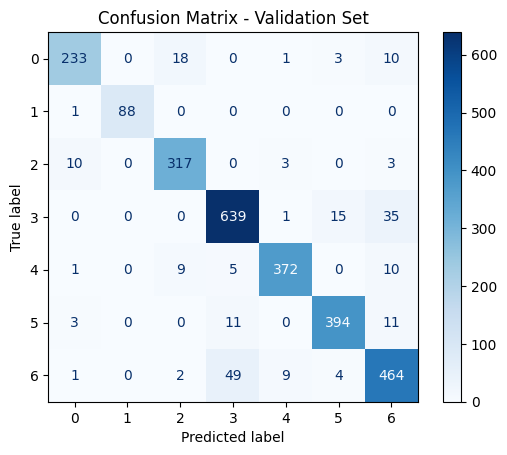

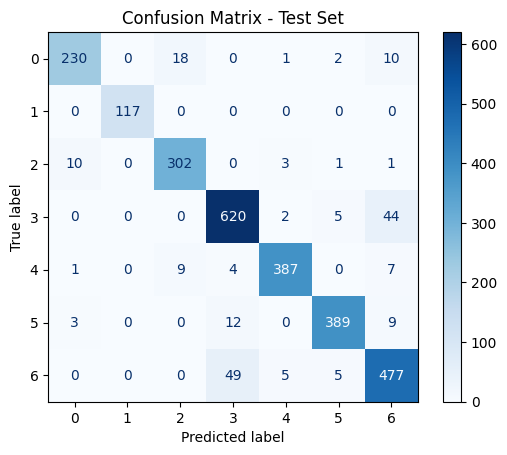

In [20]:
# Plot the confusion matrix for the validation set
y_val_pred = best_rf_model.predict(X_valid)
cm = confusion_matrix(y_valid_encoded, y_val_pred, labels=best_rf_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Validation Set')
plt.show()

# Plot the confusion matrix for the test set
y_test_pred = best_rf_model.predict(X_test)
cm = confusion_matrix(y_test_encoded, y_test_pred, labels=best_rf_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Test Set')
plt.show()

#### ROC Curve

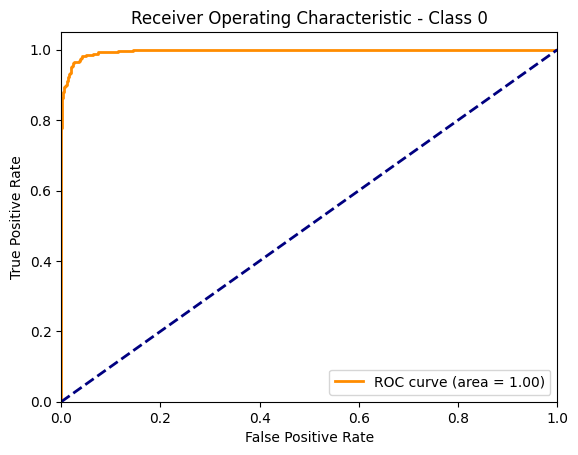

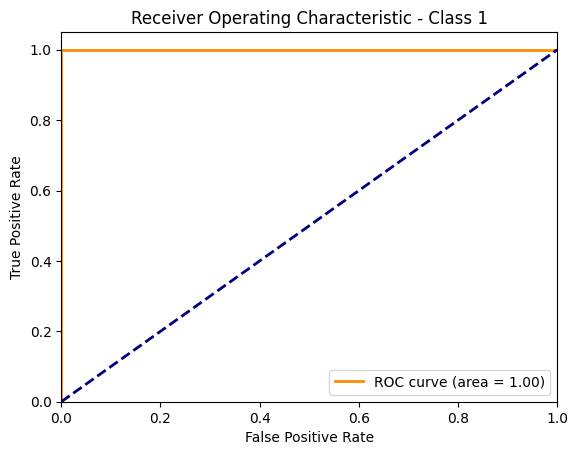

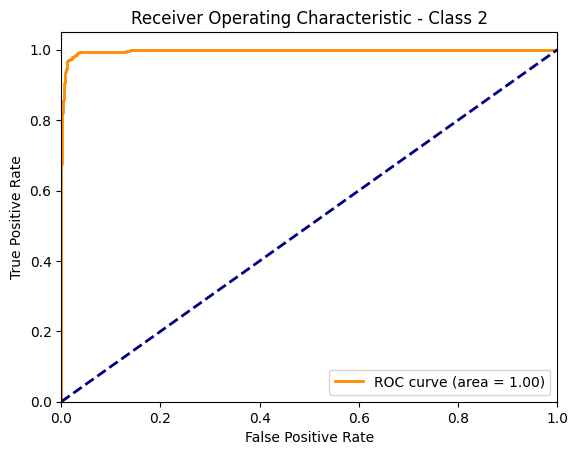

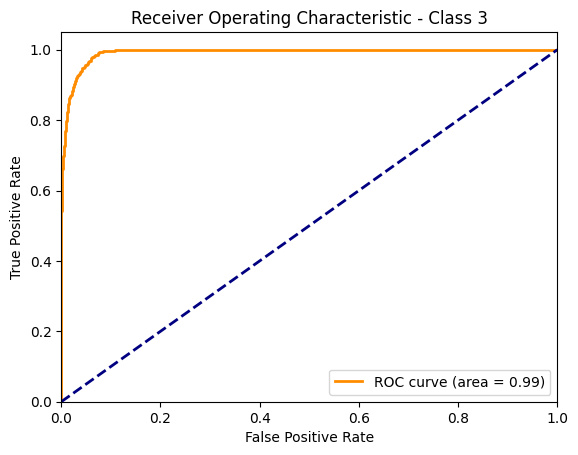

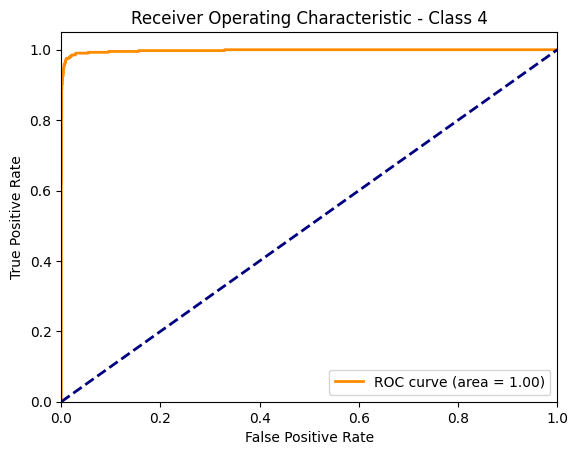

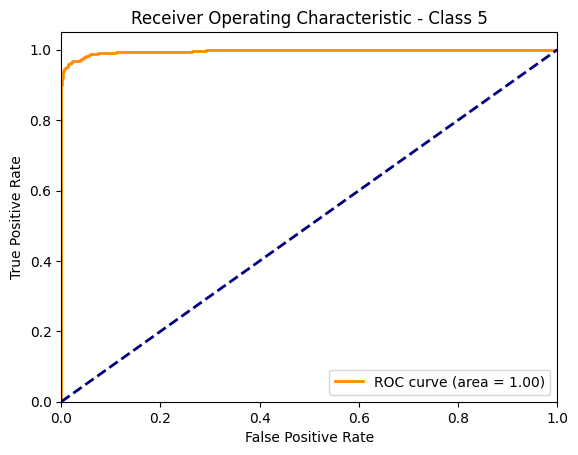

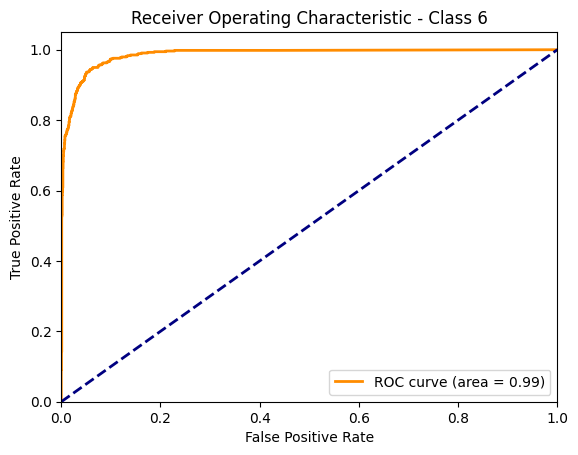

In [21]:
# Binarize the output
y_test_binarized = label_binarize(y_test_encoded, classes=range(len(label_encoder.classes_)))
y_score = best_rf_model.predict_proba(X_test)  # Predict probabilities

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
for i in range(len(label_encoder.classes_)):
    plt.figure()
    plt.plot(fpr[i], tpr[i], color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - Class {i}')
    plt.legend(loc="lower right")
    plt.show()

#### Feature Importance

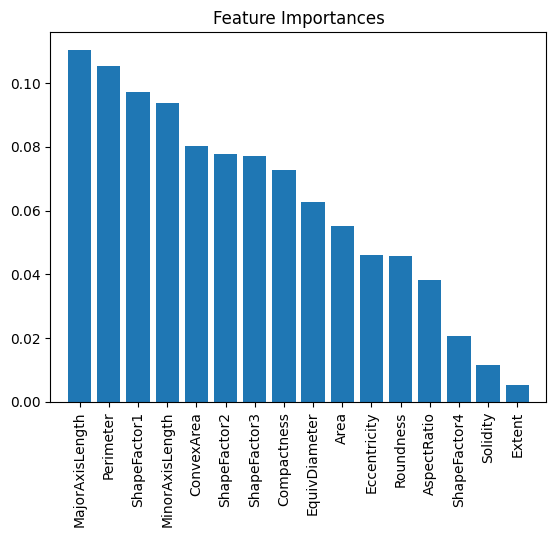

In [28]:
# Feature importances from the Random Forest model
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Extract feature names from the 'variables' key
feature_names = dry_bean_dataset['variables']['name'][:-1]  # Exclude the 'Class' target column

# Ensure that feature_names is a list of strings
feature_names = feature_names.tolist()

# Feature importances from the Random Forest model
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure()
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

## Multi-Layer Perceptron (MLP) Classifier

Epoch 1/50 - Training loss: 0.6177833098663043 - Validation loss: 0.28743351376152526
Epoch 2/50 - Training loss: 0.24751640635008565 - Validation loss: 0.24084820716821573
Epoch 3/50 - Training loss: 0.22059359015448568 - Validation loss: 0.22593847192736746
Epoch 4/50 - Training loss: 0.2116842745127131 - Validation loss: 0.21782997461670345
Epoch 5/50 - Training loss: 0.20649965230098502 - Validation loss: 0.21307616856640849
Epoch 6/50 - Training loss: 0.2028250174228751 - Validation loss: 0.21222119893516517
Epoch 7/50 - Training loss: 0.19911498706714922 - Validation loss: 0.20876770585806692
Epoch 8/50 - Training loss: 0.19576647087891538 - Validation loss: 0.20762597751321696
Epoch 9/50 - Training loss: 0.19385170316371025 - Validation loss: 0.20256855398449197
Epoch 10/50 - Training loss: 0.1927486357229913 - Validation loss: 0.20386032456306097
Epoch 11/50 - Training loss: 0.1905033707713486 - Validation loss: 0.20582935698289556
Epoch 12/50 - Training loss: 0.189357594205996

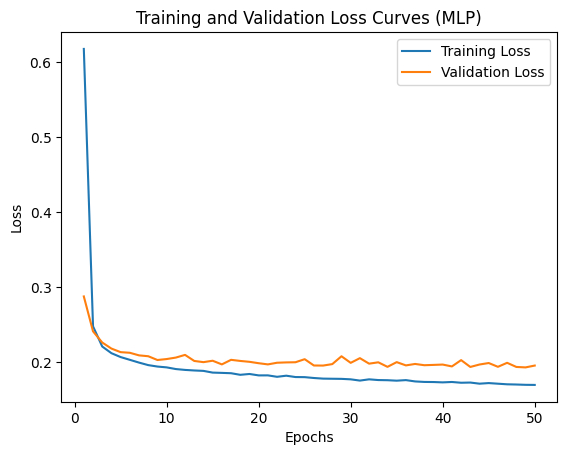

Test Accuracy: 93.10%


In [32]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        # Define the first fully connected layer
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # Define the activation function (ReLU)
        self.relu = nn.ReLU()
        # Define the second fully connected layer
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Pass the input through the first fully connected layer
        out = self.fc1(x)
        # Apply the ReLU activation function
        out = self.relu(out)
        # Pass the result through the second fully connected layer
        out = self.fc2(out)
        return out

# Training function with loss tracking
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Validation loss
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()

        val_losses.append(valid_loss / len(val_loader))

        print(f"Epoch {epoch+1}/{epochs} - Training loss: {running_loss/len(train_loader)} - Validation loss: {valid_loss/len(val_loader)}")

    return train_losses, val_losses

# Hyperparameters for MLP
input_dim = X_train.shape[1]  # Number of input features
hidden_dim = 64  # Number of hidden units, can be tuned
output_dim = len(label_encoder.classes_)  # Number of output classes
learning_rate = 0.001  # Learning rate, can be tuned

# Instantiate the model, loss function, and optimizer
model = MLP(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create DataLoaders for MLP training
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), y_train_tensor)
val_dataset = TensorDataset(torch.tensor(X_valid, dtype=torch.float32), y_valid_tensor)
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # Training data loader with shuffling
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)  # Validation data loader without shuffling
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)  # Test data loader without shuffling

# Train the MLP model and get loss values
train_losses, val_losses = train_model(model, criterion, optimizer, train_loader, val_loader, epochs=50)

# Plot training and validation loss curves
plt.figure()
plt.plot(range(1, 51), train_losses, label='Training Loss')
plt.plot(range(1, 51), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves (MLP)')
plt.legend()
plt.show()

# Evaluation
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation for evaluation
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)
    outputs = model(X_test_tensor)  # Forward pass on the test set
    _, predicted = torch.max(outputs, 1)  # Get the predicted class with the highest score
    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)  # Calculate accuracy

# Print the test accuracy
print(f'Test Accuracy: {accuracy * 100:.2f}%')


#### Confusion Matrix

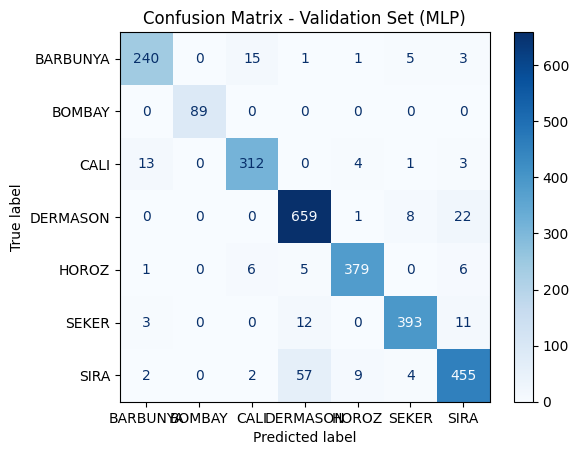

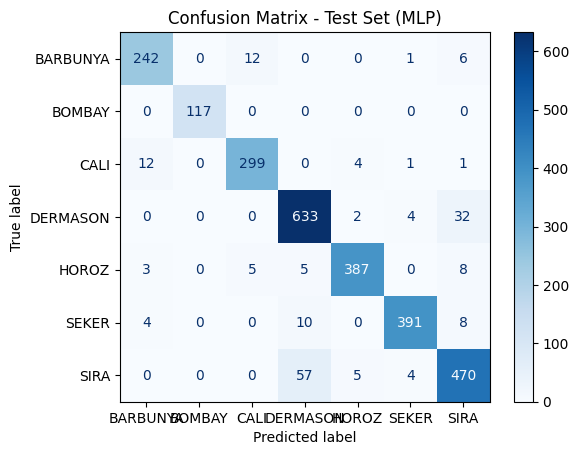

In [30]:
# Confusion Matrix for Validation Set
y_val_pred_mlp = model(torch.tensor(X_valid, dtype=torch.float32)).argmax(dim=1).numpy()
cm = confusion_matrix(y_valid_encoded, y_val_pred_mlp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Validation Set (MLP)')
plt.show()

# Confusion Matrix for Test Set
y_test_pred_mlp = model(torch.tensor(X_test, dtype=torch.float32)).argmax(dim=1).numpy()
cm = confusion_matrix(y_test_encoded, y_test_pred_mlp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Test Set (MLP)')
plt.show()

#### ROC Curve

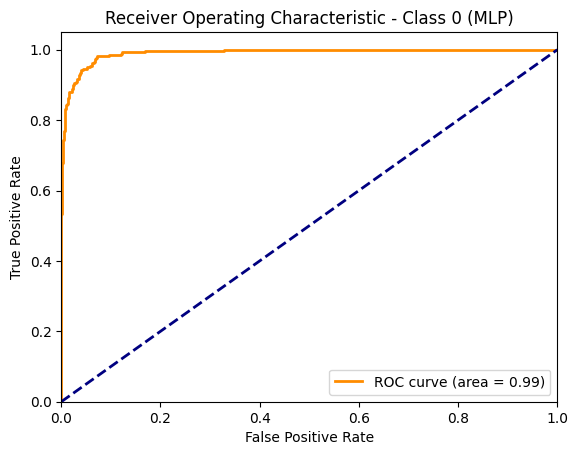

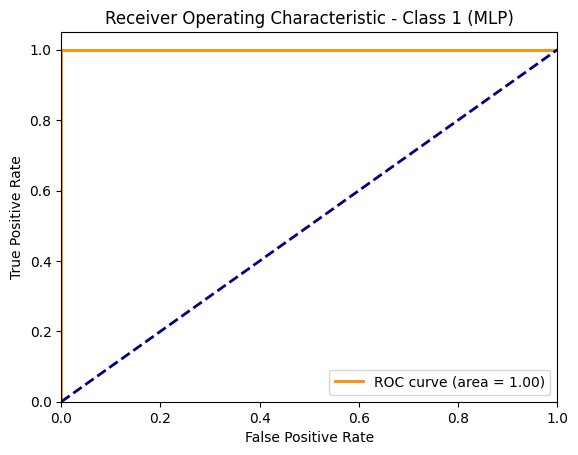

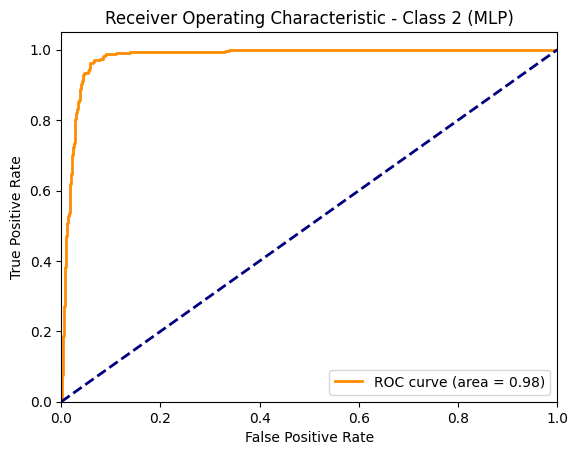

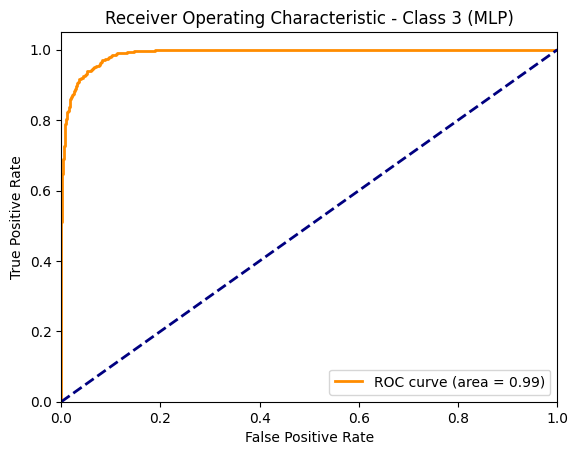

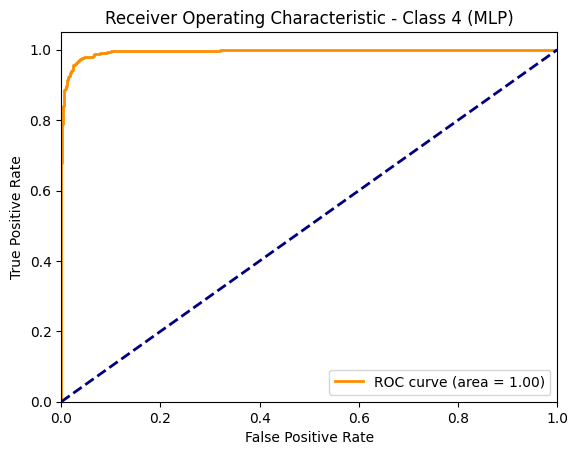

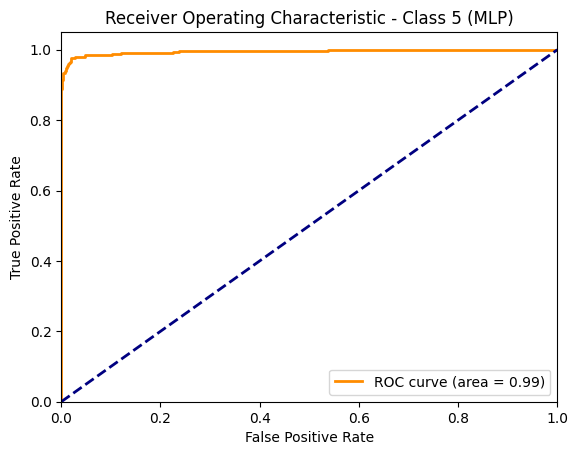

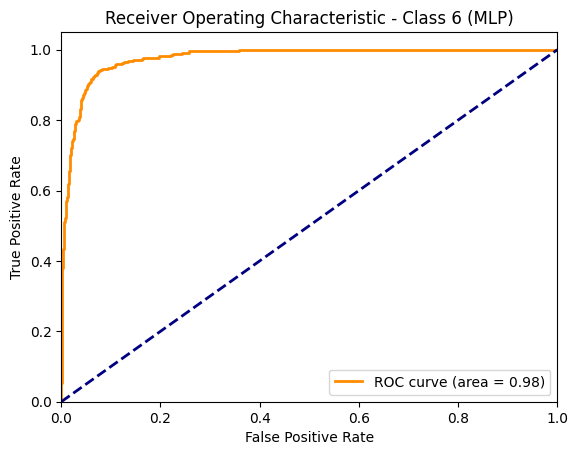

In [31]:
# Binarize the output
y_test_binarized = label_binarize(y_test_encoded, classes=range(len(label_encoder.classes_)))
y_score_mlp = model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy()  # Predict probabilities

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score_mlp[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
for i in range(len(label_encoder.classes_)):
    plt.figure()
    plt.plot(fpr[i], tpr[i], color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - Class {i} (MLP)')
    plt.legend(loc="lower right")
    plt.show()